<b>Author:</b> <a href="http://about.giuliorossetti.net">Giulio Rossetti</a><br/>
<b>Python version:</b>  3.7<br/>
<b>Packages:</b> `networkx`, `python-louvain`, `demon`, `pquality`, `nf1` <br/>
<b>Last update:</b> 30/07/2020
</span>

<a id='top'></a>
# *Intro to Community Discovery*

Community Dyscovery is one of the most challenging task in complex network analysis. <br/>
In this notebook we will discover how to extract different types of communitiesfrom a same graph using python and how to evaluate and compare them.

**Note:** this notebook is purposely not 100% comprehensive, it only discusses the basic things you need to get started. 

## Table of Contents

1. [Community Discover Algorithms](#cd)
    1. [Girvan-Newman](#gn)
    2. [K-Cliques](#kc)
    3. [Louvain](#lv)
    4. [Label Propagation](#lp)
    5. [Demon](#dm)
2. [Evaluating Partition Quality](#eval)
3. [Comparing partitions](#comparing)
    1. [Normalized Mutual Information (NMI)](#nmi)
    2. [NF1 score](#nf1)
4. [LFR: Synthetic networks with planted community structure](#lfr)

In [1]:
%matplotlib inline
import networkx as nx

In the following examples we will make use of a classic dataset: the Zachary Karate Club network.

In [2]:
g = nx.karate_club_graph()

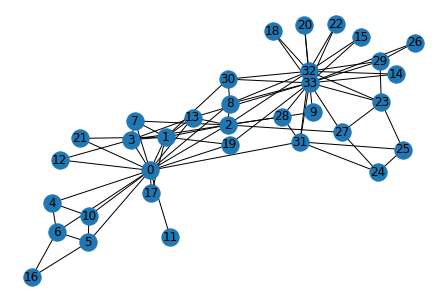

In [3]:
nx.draw(g, with_labels=True)

<a id='cd'></a>
# 1. Community Discovery Algorithms ([to top](#top))

All the algorithms we will discuss are available within the networkx library or in ad-hoc libraries that extend it.

In [4]:
from networkx.algorithms import community

<a id='gn'></a>
### A. Girvan-Newman ([to top](#top))

GN is one of the first CD algorithms. It provides a hierachical decomposition of the graph obtained removing its edges by decreasing value of betweenness cenrality. The algorithm produce non overlapping partitions that assure full node coverage.

```
Girvan M. and Newman M. E. J., 
"Community structure in social and biological networks" 
Proc. Natl. Acad. Sci. USA 99, 7821–7826 (2002)
```

In [5]:
gn_hierarchy = community.girvan_newman(g)

In [6]:
[tuple(x) for x in next(gn_hierarchy)]

[(0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21),
 (2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33)]

In [7]:
[tuple(x) for x in next(gn_hierarchy)]

[(0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21),
 (32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31),
 (9,)]

In [8]:
coms_gn = [tuple(x) for x in next(gn_hierarchy)]

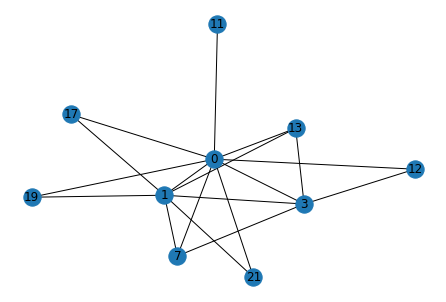

In [9]:
nx.draw(g.subgraph(coms_gn[0]), with_labels=True)

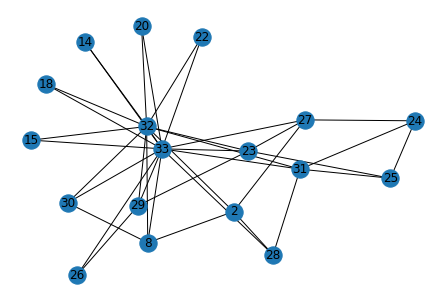

In [10]:
nx.draw(g.subgraph(coms_gn[1]), with_labels=True)

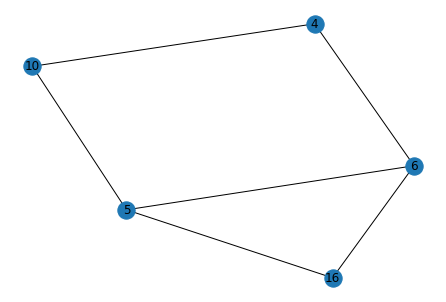

In [11]:
nx.draw(g.subgraph(coms_gn[2]), with_labels=True)

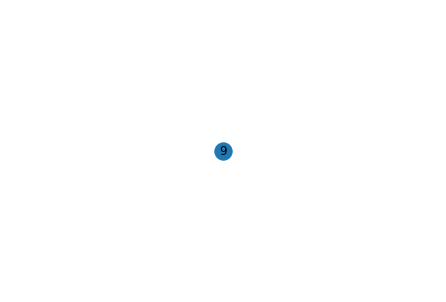

In [12]:
nx.draw(g.subgraph(coms_gn[3]), with_labels=True)

<a id='kc'></a>
### B. K-Cliques ([to top](#top))

K-cliques is a percolation algorithm that searches for chains of cliques of size *k-1* (where *k* is a user defined value). A k-clique community is the union of all cliques of size k that can be reached through adjacent (sharing k-1 nodes) k-cliques.

The algorithm produces overlapping partitions (nodes may belong to multiple communities), not assuring a complete node coverage (some nodes can be excluded by the partition).

```
Gergely Palla, Imre Derényi, Illés Farkas, and Tamás Vicsek
"Uncovering the overlapping community structure of complex networks in nature and society" 
Nature 435, 814-818, 2005, doi:10.1038/nature03607
```

In [13]:
kclique4 = list(community.k_clique_communities(g, 4))
kclique4 = [tuple(x) for x in kclique4]
kclique4

[(0, 1, 2, 3, 7, 13), (32, 33, 8, 30), (32, 33, 29, 23)]

In [14]:
kclique5 = list(community.k_clique_communities(g, 5))
kclique5 = [tuple(x) for x in kclique5]
kclique5

[(0, 1, 2, 3, 7, 13)]

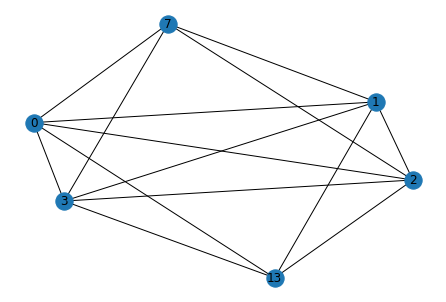

In [15]:
nx.draw(g.subgraph(kclique5[0]), with_labels=True)

<a id='lv'></a>
### C. Louvain ([to top](#top))

Louvain is a *modularity* optimization algorithm. It produces hierarchical, non overlapping, partitions having complete node coverage. The algorithm return the level of the hierarchy having optimal (maximum) modularity.
```
Blondel, V. D., Guillaume, J. L., Lambiotte, R., & Lefebvre, E.
"Fast unfolding of communities in large networks" 
Journal of statistical mechanics: theory and experiment, 2008(10), P10008.
```

In [16]:
! pip install python-louvain

In [17]:
import community as louvain
from collections import defaultdict

In [18]:
coms = louvain.best_partition(g)

# Reshaping the results to make them in the same format of the other CD algorithms
coms_to_node = defaultdict(list)
for n, c in coms.items():
    coms_to_node[c].append(n)

coms_louvain = [tuple(c) for c in coms_to_node.values()]
coms_louvain

[(0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21),
 (4, 5, 6, 10, 16),
 (8, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33),
 (23, 24, 25, 27, 28, 31)]

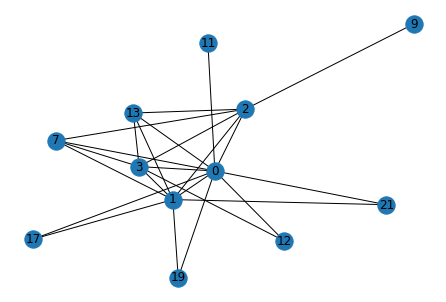

In [19]:
nx.draw(g.subgraph(coms_louvain[0]), with_labels=True)

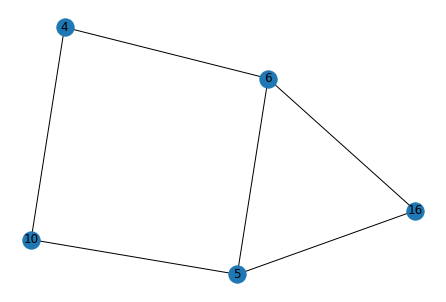

In [20]:
nx.draw(g.subgraph(coms_louvain[1]), with_labels=True)

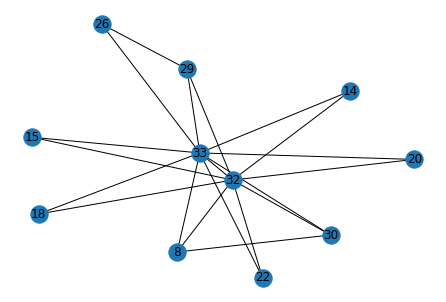

In [21]:
nx.draw(g.subgraph(coms_louvain[2]), with_labels=True)

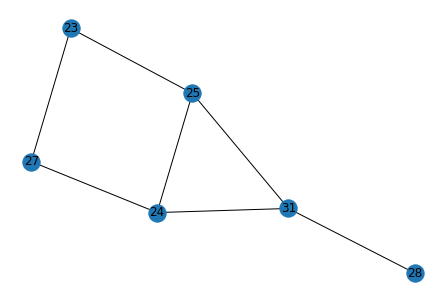

In [22]:
nx.draw(g.subgraph(coms_louvain[3]), with_labels=True)

<a id='lp'></a>
### D. Label Propagation ([to top](#top))

Generates community sets determined by label propagation.
The algorithm produces a complete, non overlapping, node coverage.
```
Cordasco, G., & Gargano, L.
"Community detection via semi-synchronous label propagation algorithms"
In Business Applications of Social Network Analysis (BASNA), 
2010 IEEE International Workshop on (pp. 1-8). IEEE.
```

In [23]:
lp = list(community.label_propagation_communities(g))
lp = [tuple(x) for x in lp]
lp

[(32, 33, 2, 8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 28, 29, 30),
 (16, 5, 6),
 (0, 1, 3, 4, 7, 10, 11, 12, 13, 17, 19, 21, 24, 25, 31)]

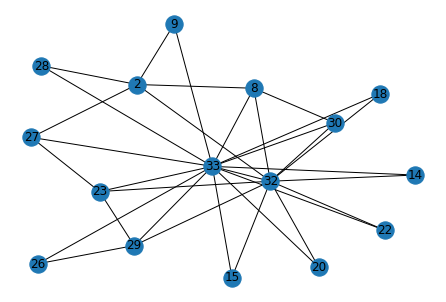

In [24]:
nx.draw(g.subgraph(lp[0]), with_labels=True)

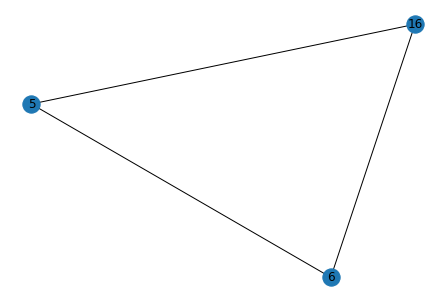

In [25]:
nx.draw(g.subgraph(lp[1]), with_labels=True)

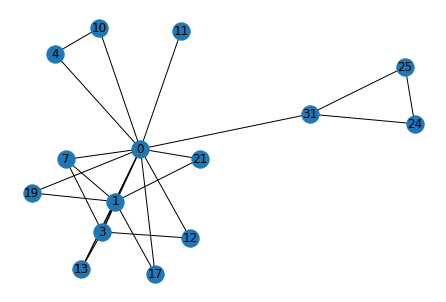

In [26]:
nx.draw(g.subgraph(lp[2]), with_labels=True)

<a id='dm'></a>
### E. Demon ([to top](#top))

Demon is a node-centric, bottom-up, overlapping community discovery algorithm. 
It leverages ego-networks to include individual node's perspectivesin the community identification phase.
Demon do not guarantee complete node coverage.

```
Coscia, Michele; Rossetti, Giulio; Giannotti, Fosca; Pedreschi, Dino
"DEMON: a Local-First Discovery Method for Overlapping Communities" 
SIGKDD international conference on knowledge discovery and data mining, pp. 615-623, 
IEEE ACM, 2012, ISBN: 978-1-4503-1462-6.
```

In [27]:
! pip install demon

In [28]:
import demon as dm
d = dm.Demon(graph=g, min_community_size=3, epsilon=0.5)
coms_demon = d.execute()
coms_demon

Exec: 100%|████████████████████████

Time:  'execute' 0.03 sec
------------------------------------


[(0, 4, 5, 6, 10, 16),
 (0, 1, 2, 3, 7, 8, 12, 13, 17, 19, 21, 30, 32, 33),
 (2, 8, 14, 15, 18, 20, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33)]

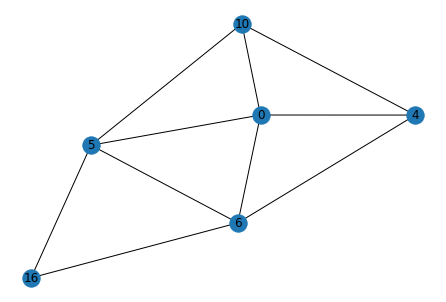

In [29]:
nx.draw(g.subgraph(coms_demon[0]), with_labels=True)

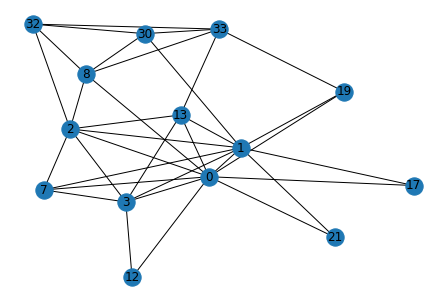

In [30]:
nx.draw(g.subgraph(coms_demon[1]), with_labels=True)

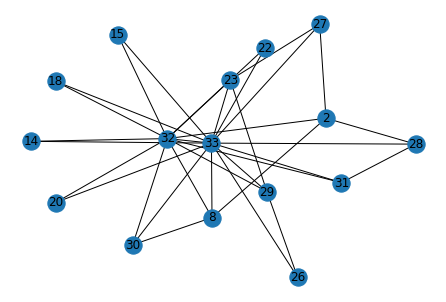

In [31]:
nx.draw(g.subgraph(coms_demon[2]), with_labels=True)

<a id='eval'></a>
# 2. Evaluating Partition Quality ([to top](#top))

We will use the *pquality* package that implements the community quality functions described in:
```
Yang, Jaewon, and Jure Leskovec. 
"Defining and evaluating network communities based on ground-truth."  
Knowledge and Information Systems 42.1 (2015): 181-213.
```

In [32]:
! pip install pquality

In [33]:
import pquality

In [34]:
coms = coms_louvain 
#coms = coms_gn
#coms = coms_demon
results = pquality.pquality_summary(g, coms)
results['Indexes']

,min,max,avg,std
Index,,,,
Internal Density,0.363636,0.600000,0.448485,0.097064
Edges inside,6.000000,24.000000,14.250000,7.885905
Average Degree,2.333333,4.000000,3.092424,0.737434
FOMD,0.400000,0.500000,0.463636,0.041161
TPR,0.500000,1.000000,0.733333,0.195789
Expansion,0.800000,1.666667,1.226515,0.308774
Cut Ratio,0.027586,0.059524,0.048869,0.012506
Conductance,0.225806,0.416667,0.287933,0.075321
Normalized Cut,0.277027,0.482456,0.366749,0.074371


In [35]:
results['Modularity']

,value
Index,
Modularity (no overlap),0.418803


<a id='comparing'></a>
# 3. Comparing partitions ([to top](#top))

Comparing partitions produced by different community discovery algorithms is not an easy task. 

Among the different measures that can be used we recall the Normalized Mutual Information score (NMI) and the NF1 score.

<a id='nmi'></a>
### A. Normalized Mutual Information (NMI) ([to top](#top))

NMI can be used under two conditions:
- the compared partitions include the same set of nodes (i.e. both provide a complete coverage)
- each of the compared partitions is not overlapping (i.e., in each partition any node belongs to one and only community)
```
Lancichinetti, A., Fortunato, S., Radicchi, F.
Benchmark graphs for testing community detection algorithms. 
Phys. Rev. E, 78(4), 046110 (2008). http://pre.aps.org/abstract/PRE/v78/i4/e046110
```

In [36]:
from sklearn.metrics import normalized_mutual_info_score

In [37]:
def nmi_preprocess(partition):
    return [x[1] for x in sorted([(node,nid) for nid, cluster in enumerate(partition) for node in cluster], 
                                 key=lambda x: x[0])]

In [38]:
lp_labels = nmi_preprocess(lp)
louvain_labels = nmi_preprocess(coms_louvain)
gn_labels = nmi_preprocess(coms_gn)

In [39]:
normalized_mutual_info_score(lp_labels, louvain_labels)

0.48842970280856995

In [40]:
normalized_mutual_info_score(gn_labels, lp_labels)

0.5888520007130441

In [41]:
normalized_mutual_info_score(gn_labels, louvain_labels)

0.7344859355312199

<a id='nf1'></a>
### B. NF1 score ([to top](#top))

The NF1 score is an alternative to NMI that can be used to compare any kind of partitions (overlapping/non overlapping, complete/partial coverage). It allows also to visualize the results in a Precision-Recall space.

```
Giulio Rossetti, Luca Pappalardo, and Salvatore Rinzivillo
"A novel approach to evaluate community detection algorithms on ground truth" 
7th Workshop on Complex Networks, Springer-Verlag, 2016.

Rossetti, Giulio
"RDyn: graph benchmark handling community dynamics." 
Journal of Complex Networks 5.6 (2017): 893-912.
```

In [42]:
! pip install nf1

In [43]:
from nf1 import NF1

In [44]:
nf = NF1(lp, coms_louvain)
results = nf.summary()

In [45]:
results['scores']

,Value
Index,
Ground Truth Communities,4.000
Identified Communities,3.000
Community Ratio,0.750
Ground Truth Matched,0.750
Node Coverage,1.000
NF1,0.575


In [46]:
results['details']

,F1 min,F1 max,F1 mean,F1 mode,F1 std
0,0.74,0.81,0.766667,0.74,0.030912


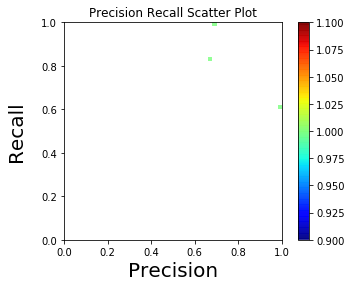

In [47]:
nf.plot()

<a id='lfr'></a>
# 4. LFR: Synthetic networks with planted community structure ([to top](#top))

A standard way to compare a set of CD algorithms is to test them against a synthetic graph having known community structure. The classic generator used in this scenario is the LFR one.
LFR produce a graph and a ground truth partition which is non overlapping and complete.

```
Lancichinetti, A., Fortunato, S., Radicchi, F.
Benchmark graphs for testing community detection algorithms. 
Phys. Rev. E, 78(4), 046110 (2008). http://pre.aps.org/abstract/PRE/v78/i4/e046110
```

In [48]:
from networkx.generators.community import LFR_benchmark_graph

#### Parameters ####
n = 250 # number of nodes
tau1 = 3 # Power law exponent for the degree distribution of the created graph
tau2 = 1.5 # Power law exponent for the community size distribution in the created graph.
mu = 0.1 # Fraction of intra-community edges incident to each node
###################

lgr_graph = LFR_benchmark_graph(n, tau1, tau2, mu, average_degree=5, min_community=20, seed=10)

In [49]:
# Reshaping the communities
ground_truth_communities = [c for c in {tuple(m[1]['community']): None for m in lgr_graph.nodes.data()}]

In [50]:
# Computing a partition (i.e., using Label propagation)
lp_coms_lfr = list(community.label_propagation_communities(lgr_graph))
lp_coms_lfr = [tuple(x) for x in lp_coms_lfr]

In [51]:
# Preprocessing
lfr_gt = nmi_preprocess(ground_truth_communities)
lp_lfr = nmi_preprocess(lp_coms_lfr)

In [52]:
# Computing NMI
normalized_mutual_info_score(lfr_gt, lp_lfr)

0.5564344043975633

In [53]:
# Computing NF1
nf = NF1(lp_coms_lfr, ground_truth_communities)
results = nf.summary()

In [54]:
results['scores']

,Value
Index,
Ground Truth Communities,3.000000
Identified Communities,26.000000
Community Ratio,8.666667
Ground Truth Matched,1.000000
Node Coverage,1.000000
NF1,0.017514


In [55]:
results['details']

,F1 min,F1 max,F1 mean,F1 mode,F1 std
0,0.01,0.96,0.151786,0.05,0.207262


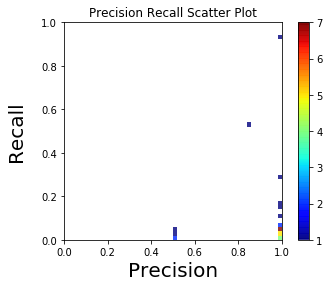

In [56]:
nf.plot()

<a id='end'></a>
# 5. Conclusions ([to top](#top))

We have seen how to extract communities in python using five different algorithms, how to evaluate and compare them.

Community discovery results can also be analysed with the aim of producing a characterization of the identified substructures. Common studies involve:
- Community size distribution
- Community density distribution
- Node overlap distribution
- External data homophily analysis